In [23]:
import numpy as np
import pandas as pd
import math
import time
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec

from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.colors import Normalize

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Data exploration and processing:

In [3]:
sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
sfrs = sfrs[sfrs["AVG"].notna()].copy()
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()
sfrs_flag_not0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] != 0.0].copy()

print("Total records in sfrs (before filtering by image/spectrum):", len(sfrs))
print("Total records after filtering by image/spectrum availability:", len(sfrs))
print("Total records after removing NaN in AVG:", len(sfrs))
print("Total records after filtering AVG >= -80:", len(sfrs_filtered))
print("Among them, FLAG == 0:", len(sfrs_flag0_filtered))
print("Among them, FLAG != 0:", len(sfrs_flag_not0_filtered))

sfrs_flag0 = sfrs[sfrs["FLAG"] == 0.0]
labels_pie = ["FLAG == 0", "FLAG != 0"]
sizes = [len(sfrs_flag0), len(sfrs) - len(sfrs_flag0)]

Total records in sfrs (before filtering by image/spectrum): 34613
Total records after filtering by image/spectrum availability: 34613
Total records after removing NaN in AVG: 34613
Total records after filtering AVG >= -80: 30752
Among them, FLAG == 0: 16841
Among them, FLAG != 0: 13911


In [4]:
mask_all = np.in1d(metadata_indices, sfrs_filtered.index)
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)
selected_all = metadata_indices[mask_all]
selected_flag0 = metadata_indices[mask_flag0]

all_images = []
all_spectra = []
filtered_images = []
filtered_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask_all]
        spectra_zoom = cube[spec_key][:][mask_all]
    all_images.append(images_zoom)
    all_spectra.append(spectra_zoom)
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom_flag0 = cube[img_key][:][mask_flag0]
        spectra_zoom_flag0 = cube[spec_key][:][mask_flag0]
    filtered_images.append(images_zoom_flag0)
    filtered_spectra.append(spectra_zoom_flag0)

print("All images shape (zoom 0):", all_images[0].shape)
print("Filtered images shape (zoom 0):", filtered_images[0].shape)
print("All spectra shape (zoom 0):", all_spectra[0].shape)
print("Filtered spectra shape (zoom 0):", filtered_spectra[0].shape)

All images shape (zoom 0): (30752, 5, 64, 64)
Filtered images shape (zoom 0): (16841, 5, 64, 64)
All spectra shape (zoom 0): (30752, 4620)
Filtered spectra shape (zoom 0): (16841, 4620)


In [5]:
nan_counts_all = np.sum(np.isnan(all_spectra[0]), axis=1)
nan_counts_flag0 = np.sum(np.isnan(filtered_spectra[0]), axis=1)
total_length = all_spectra[0].shape[1]

total_length = all_spectra[0].shape[1]
wavelengths = np.linspace(3800, 9200, total_length)

fraction_nan_all = np.mean(np.isnan(all_spectra[0]), axis=0)
fraction_nan_flag0 = np.mean(np.isnan(filtered_spectra[0]), axis=0)

### Delete all the spectra that contain nan:

In [6]:
mask_clean_all = ~np.isnan(all_spectra[0]).any(axis=1)
mask_clean_flag0 = ~np.isnan(filtered_spectra[0]).any(axis=1)

cleaned_all_images = [arr[mask_clean_all] for arr in all_images]
cleaned_all_spectra = [arr[mask_clean_all] for arr in all_spectra]

cleaned_filtered_images = [arr[mask_clean_flag0] for arr in filtered_images]
cleaned_filtered_spectra = [arr[mask_clean_flag0] for arr in filtered_spectra]

selected_all_clean = selected_all[mask_clean_all]
selected_flag0_clean = selected_flag0[mask_clean_flag0]

cleaned_sfrs_all = sfrs_filtered.loc[selected_all_clean]
cleaned_sfrs_flag0 = sfrs_flag0_filtered.loc[selected_flag0_clean]

print("Cleaned All spectra shape (zoom 0):", cleaned_all_spectra[0].shape)
print("Cleaned FLAG==0 spectra shape (zoom 0):", cleaned_filtered_spectra[0].shape)
print("Spectra removed (all):", all_spectra[0].shape[0] - cleaned_all_spectra[0].shape[0])
print("Spectra removed (FLAG==0):", filtered_spectra[0].shape[0] - cleaned_filtered_spectra[0].shape[0])

print("\nCleaned All images shape (zoom 0):", cleaned_all_images[0].shape)
print("Cleaned FLAG==0 images shape (zoom 0):", cleaned_filtered_images[0].shape)
print("Images removed (all):", all_images[0].shape[0] - cleaned_all_images[0].shape[0])
print("Images removed (FLAG==0):", filtered_images[0].shape[0] - cleaned_filtered_images[0].shape[0])

print("\nCleaned SFR (all) shape:", cleaned_sfrs_all.shape)
print("Cleaned SFR (FLAG==0) shape:", cleaned_sfrs_flag0.shape)
print("SFR records removed (all):", sfrs_filtered.shape[0] - cleaned_sfrs_all.shape[0])
print("SFR records removed (FLAG==0):", sfrs_flag0_filtered.shape[0] - cleaned_sfrs_flag0.shape[0])


Cleaned All spectra shape (zoom 0): (20157, 4620)
Cleaned FLAG==0 spectra shape (zoom 0): (11179, 4620)
Spectra removed (all): 10595
Spectra removed (FLAG==0): 5662

Cleaned All images shape (zoom 0): (20157, 5, 64, 64)
Cleaned FLAG==0 images shape (zoom 0): (11179, 5, 64, 64)
Images removed (all): 10595
Images removed (FLAG==0): 5662

Cleaned SFR (all) shape: (20157, 284)
Cleaned SFR (FLAG==0) shape: (11179, 284)
SFR records removed (all): 10595
SFR records removed (FLAG==0): 5662


In [7]:
def normalize_images(images_list):
    normalized_list = []
    for img_array in images_list:
        min_val = np.min(img_array, axis=(2,3), keepdims=True)
        max_val = np.max(img_array, axis=(2,3), keepdims=True)
        norm_img = 2 * (img_array - min_val) / (max_val - min_val) - 1
        normalized_list.append(norm_img)
    return normalized_list

normalized_all_images = normalize_images(cleaned_all_images)
normalized_filtered_images = normalize_images(cleaned_filtered_images)

In [8]:
labels_flag0 = sfrs_flag0_filtered.loc[:, "TARGETTYPE"]
labels_flag_not0 = sfrs_filtered.loc[sfrs_filtered["FLAG"] != 0.0, "TARGETTYPE"]

def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

df_flag0_orig = pd.DataFrame({"TARGETTYPE": labels_flag0})
df_flag_not0_orig = pd.DataFrame({"TARGETTYPE": labels_flag_not0})

df_flag0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag0).apply(simplify_targettype)})
df_flag_not0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag_not0).apply(simplify_targettype)})

In [9]:
def normalize_spectra(spectra_list):
    normalized_list = []
    for spec in spectra_list:
        if spec.ndim == 1:
            spec = spec[np.newaxis, :]
        min_val = np.nanmin(spec, axis=1, keepdims=True)
        max_val = np.nanmax(spec, axis=1, keepdims=True)
        diff = np.where((max_val - min_val)==0, 1, max_val - min_val)
        norm_spec = 2 * (spec - min_val) / diff - 1
        normalized_list.append(norm_spec)
    result = np.empty(len(normalized_list), dtype=object)
    for i, arr in enumerate(normalized_list):
        result[i] = arr
    return result

normalized_all_spectra = normalize_spectra(cleaned_all_spectra)
normalized_filtered_spectra = normalize_spectra(cleaned_filtered_spectra)

## Getting rid of photos with multiple objects:

In [10]:
flag0_indices = cleaned_sfrs_flag0.index
all_indices = cleaned_sfrs_all.index
flag_not0_indices = all_indices.difference(flag0_indices)
mask_flag_not0 = np.isin(cleaned_sfrs_all.index, flag_not0_indices)
normalized_nonflag0_images = [arr[mask_flag_not0] for arr in normalized_all_images]

In [11]:
CROP_SIZES_4 = {
    0: 32,  # originally 64
    1: 16,  # originally 32
    2: 8,   # originally 16
    3: 4    # originally 8
}
THRESHOLD = 0.9

def detect_and_visualize_multiple_objects(images_list, thresholds, crop_sizes=None, max_objects=1, thumbnail_size=3, group_name="", print_spectra=False, spectra_list=None):
    images_trimmed = []
    for i, img_array in enumerate(images_list):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        images_trimmed.append(trimmed)
    multi_obj_indices = []
    for idx in range(images_trimmed[0].shape[0]):
        image = images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    total_images = images_trimmed[0].shape[0]
    count_multi = len(multi_obj_indices)
    percent_multi = (count_multi / total_images)*100 if total_images>0 else 0
    print(f"{group_name}: Found {count_multi} images with multiple objects from {total_images} ({percent_multi:.2f}%).")
    if multi_obj_indices:
        display_indices = multi_obj_indices[:max_objects]
        if print_spectra and spectra_list is not None:
            num_disp = len(display_indices)
            fig = plt.figure(figsize=(15, thumbnail_size * 2 * num_disp), dpi=100)
            gs = gridspec.GridSpec(2 * num_disp, 5, hspace=0.6, wspace=0.3)
            for i, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = fig.add_subplot(gs[2*i, col])
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
                ax_spec = fig.add_subplot(gs[2*i+1, :])
                spectrum = spectra_list[0][obj_idx]
                wavelengths = np.linspace(3800,9200, len(spectrum))
                ax_spec.plot(wavelengths, spectrum, color="blue", linewidth=0.3)
                ax_spec.set_title("Spectrum (Zoom 0)", fontsize=10)
                ax_spec.set_xlabel("Wavelength (Å)", fontsize=10)
                ax_spec.set_ylabel("Flux", fontsize=10)
                ax_spec.set_xlim([3800,9200])
                ax_spec.set_ylim([-1,1])
            fig.suptitle(f"Images with ≥2 objects and spectra ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.93)
            plt.show()
        else:
            num_disp = len(display_indices)
            fig, axes = plt.subplots(num_disp, 5, figsize=(15, thumbnail_size * num_disp), dpi=100)
            if num_disp == 1:
                axes = axes.reshape(1, -1)
            for row, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = axes[row, col]
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
            fig.suptitle(f"Images with ≥2 objects ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.99)
            plt.show()
    else:
        print(f"No images found for {group_name} with multiple objects.")
    return images_trimmed, multi_obj_indices

FLAG != 0 (Original): Found 1184 images with multiple objects from 8978 (13.19%).


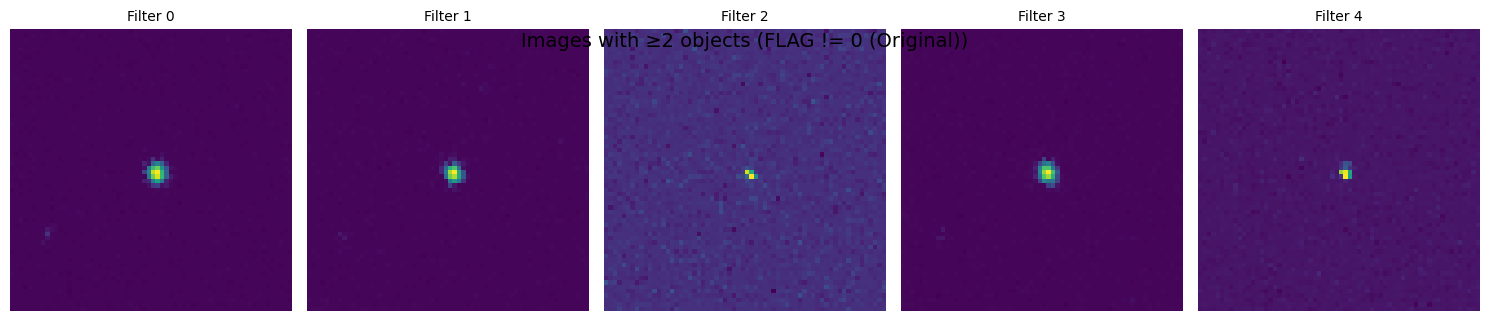

In [12]:
orig_images_flag_not0, multi_obj_indices_flag_not0 = detect_and_visualize_multiple_objects(normalized_nonflag0_images, thresholds=THRESHOLD, crop_sizes=None, group_name="FLAG != 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra)

FLAG == 0 (Original): Found 1111 images with multiple objects from 11179 (9.94%).


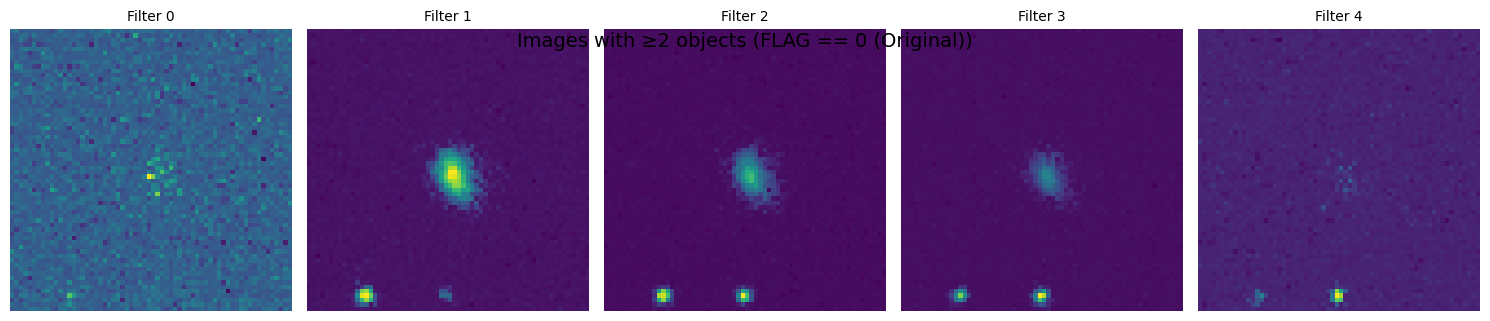

In [13]:
orig_images_flag0, multi_obj_indices_flag0 = detect_and_visualize_multiple_objects(normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=None, group_name="FLAG == 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra)

FLAG == 0 (Crop): Found 760 images with multiple objects from 11179 (6.80%).


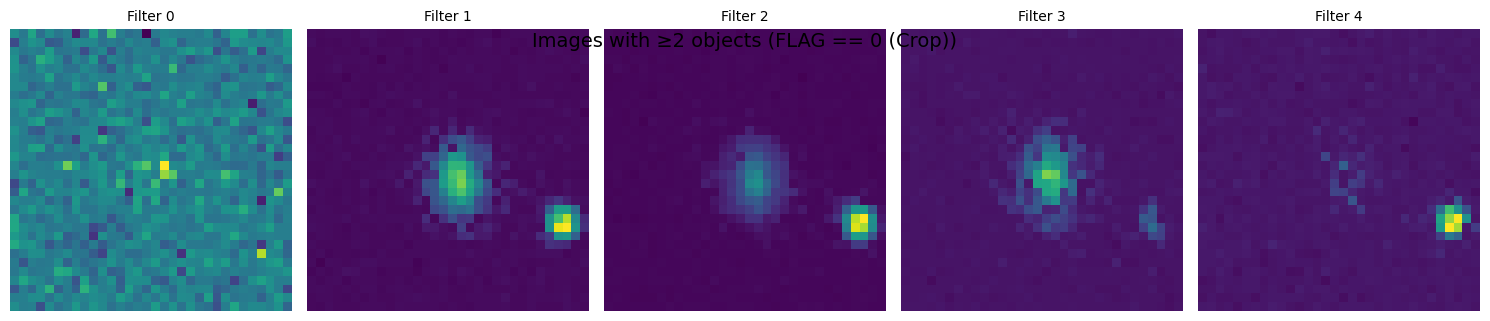

In [14]:
orig_images_flag0_crop, multi_obj_indices_flag0_crop = detect_and_visualize_multiple_objects(normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=CROP_SIZES_4, group_name="FLAG == 0 (Crop)", print_spectra=False, spectra_list=normalized_filtered_spectra)

FLAG != 0 (Crop): Found 847 images with multiple objects from 8978 (9.43%).


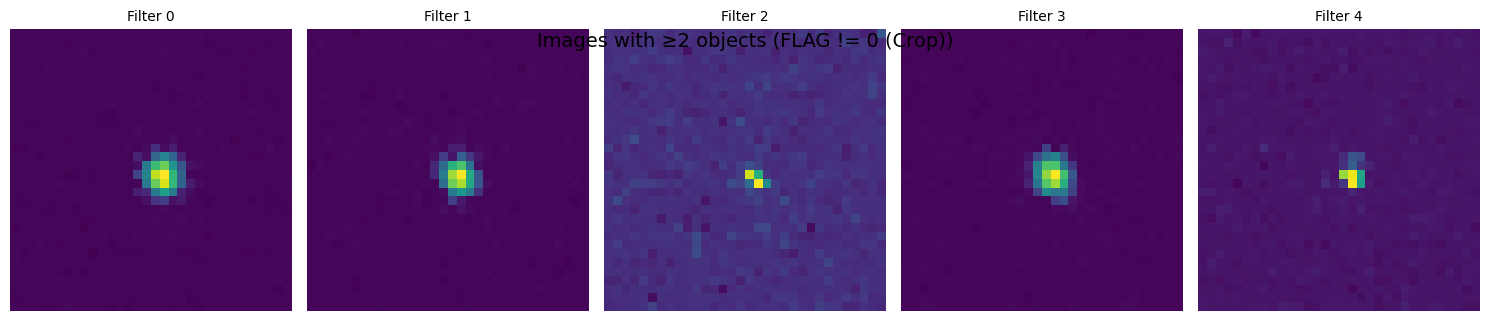

In [15]:
orig_images_flag_not0_crop, multi_obj_indices_flag_not0_crop = detect_and_visualize_multiple_objects(normalized_nonflag0_images, thresholds=THRESHOLD, crop_sizes=CROP_SIZES_4, group_name="FLAG != 0 (Crop)", print_spectra=False, spectra_list=normalized_filtered_spectra)

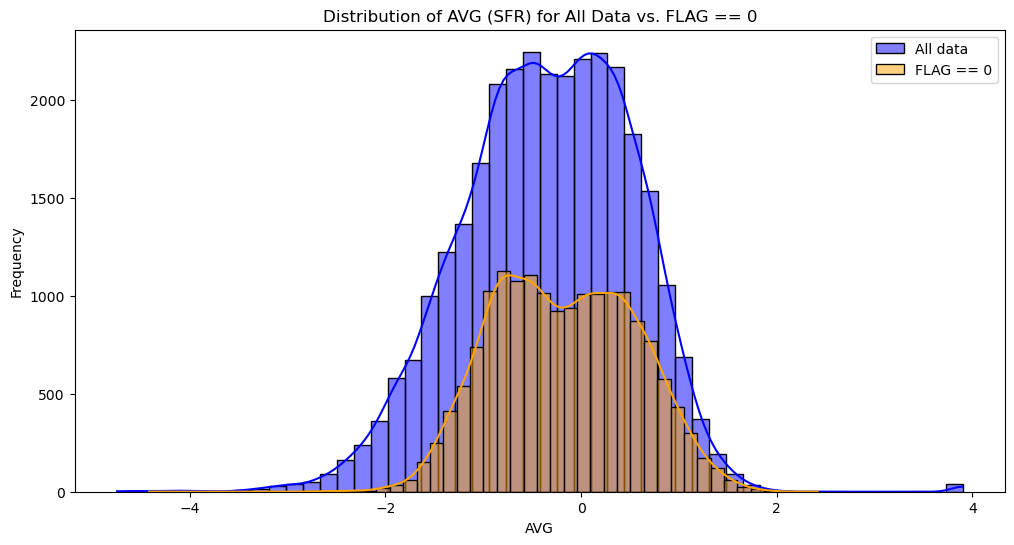

In [16]:
plt.figure(figsize=(12,6))
sns.histplot(sfrs_filtered["AVG"].dropna(), bins=50, color="blue", label="All data", kde=True)
sns.histplot(sfrs_flag0_filtered["AVG"].dropna(), bins=50, color="orange", label="FLAG == 0", kde=True)
plt.legend()
plt.title("Distribution of AVG (SFR) for All Data vs. FLAG == 0")
plt.xlabel("AVG")
plt.ylabel("Frequency")
plt.show()

In [35]:
selected_Y = cleaned_sfrs_flag0.loc[selected_flag0_clean]["AVG"].values
modalities = {"Photo": orig_images_flag0, "Spectra": normalized_filtered_spectra}
methods = {
    "t-SNE": lambda X: TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X),
    "UMAP": lambda X: umap.UMAP(n_components=2, random_state=42).fit_transform(X),
    "PCA":   lambda X: PCA(n_components=2, random_state=42).fit_transform(X)
}

results = {}
for method_name, func in methods.items():
    results[method_name] = {}
    for modality, data_list in modalities.items():
        results[method_name][modality] = {}
        for zoom in range(4):
            data = data_list[zoom]
            X = data.reshape(data.shape[0], -1) if data.ndim > 2 else data
            X = np.nan_to_num(X)
            Y = selected_Y[:X.shape[0]]
            emb = func(X)
            results[method_name][modality][zoom] = (emb, Y)

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and

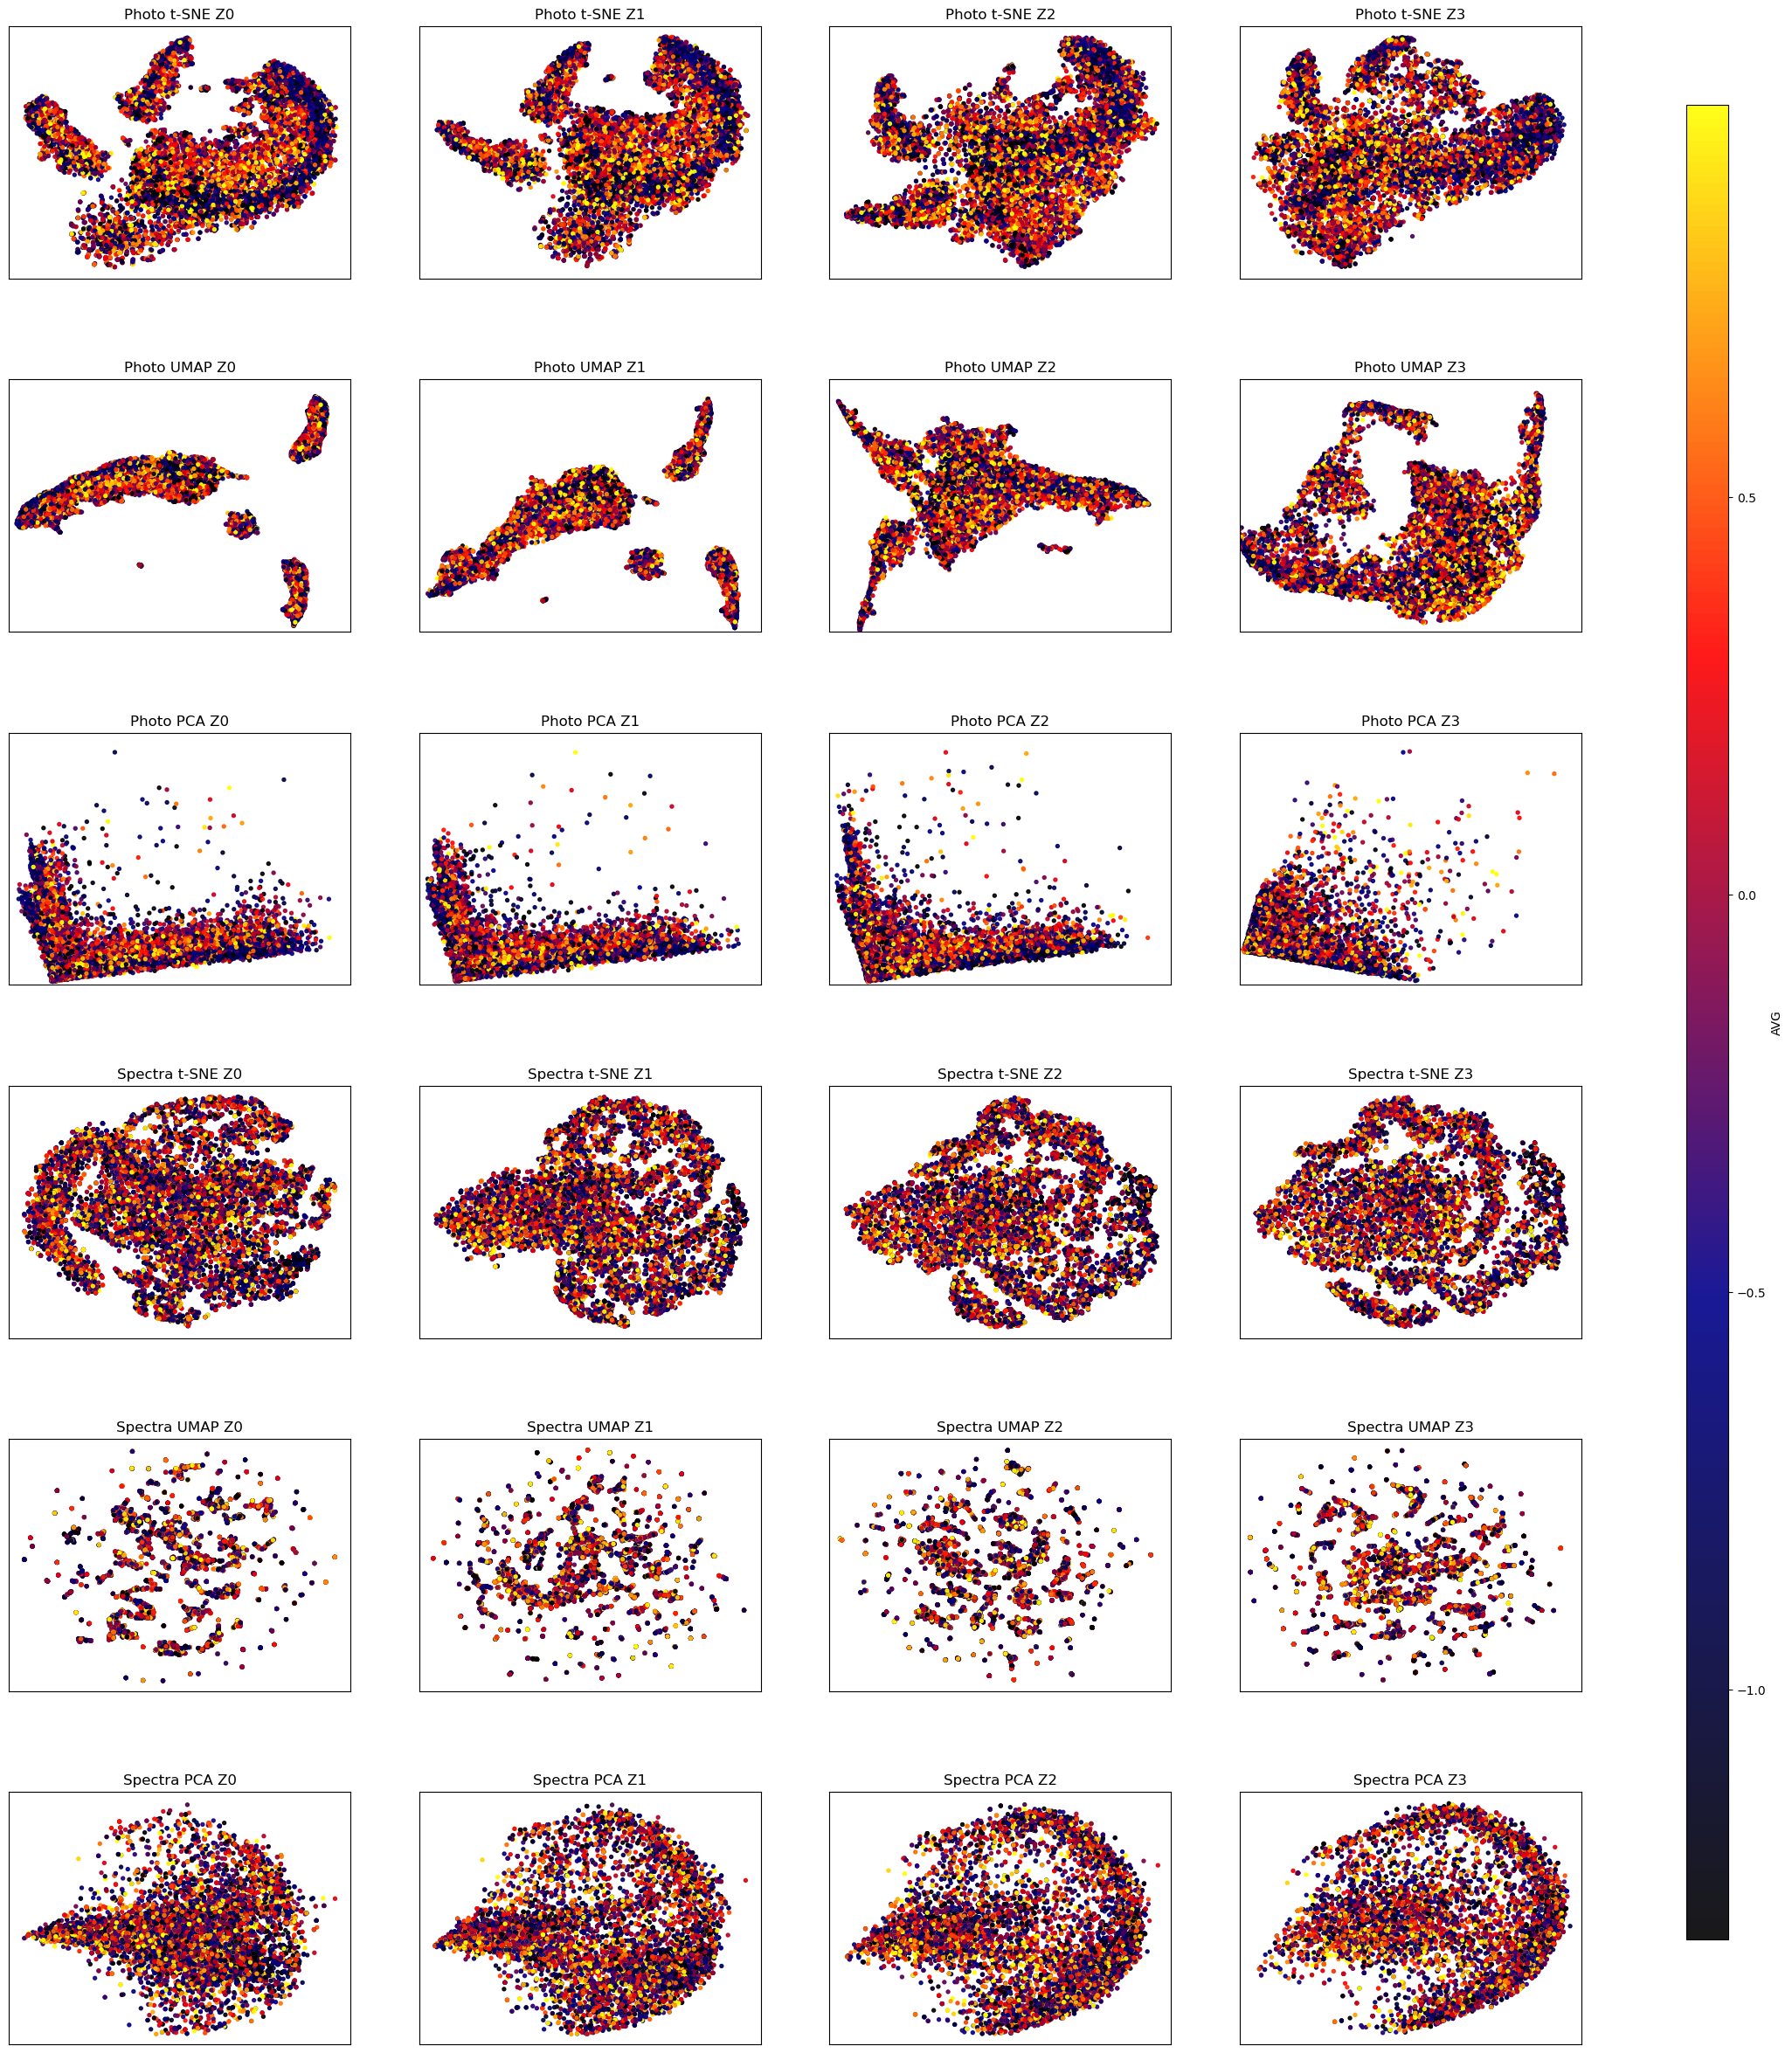

In [40]:
colors_list = [
    (0.0, "black"),
    (0.35, "darkblue"),
    (0.70, "red"),
    (1.0, "yellow")
]
custom_b = mcolors.LinearSegmentedColormap.from_list("custom_b", colors_list)

results = {}
for name, func in methods.items():
    results[name] = {}
    for mod, data_list in modalities.items():
        results[name][mod] = {}
        for z in range(4):
            d = data_list[z]
            X = d.reshape(d.shape[0], -1) if d.ndim > 2 else d
            X = np.nan_to_num(X)
            Y = selected_Y[:X.shape[0]]
            emb = func(X)
            results[name][mod][z] = (emb, Y)

vmin, vmax = np.percentile(selected_Y, [5, 95])
norm = Normalize(vmin=vmin, vmax=vmax)

fig, axes = plt.subplots(len(modalities)*len(methods), 4, figsize=(24, 30))
row = 0
for mod in modalities:
    for name in methods:
        for z in range(4):
            emb, Y = results[name][mod][z]
            ax = axes[row, z]
            sc = ax.scatter(emb[:, 0], emb[:, 1], c=Y, cmap=custom_b, norm=norm, s=8, alpha=0.9)
            ax.set_title(f"{mod} {name} Z{z}")
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_xlim(emb[:, 0].min()*1.1, emb[:, 0].max()*1.1)
            ax.set_ylim(emb[:, 1].min()*1.1, emb[:, 1].max()*1.1)
        row += 1

plt.subplots_adjust(left=0.05, right=0.8, wspace=0.2, hspace=0.4)
cax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cax, orientation="vertical").set_label("AVG")
plt.show()

In [41]:
corr_results = []
for method_name in methods:
    for modality in modalities:
        for zoom in range(4):
            emb, Y = results[method_name][modality][zoom]
            cx = np.corrcoef(emb[:, 0], Y)[0, 1]
            cy = np.corrcoef(emb[:, 1], Y)[0, 1]
            corr_results.append((f"{method_name}_{modality}_Z{zoom}", cx, cy))

print("Correlation between embedding axes and AVG:")
for key, cx, cy in corr_results:
    print(f"{key}: corr_x={cx:.2f}, corr_y={cy:.2f}")

Correlation between embedding axes and AVG:
t-SNE_Photo_Z0: corr_x=-0.03, corr_y=-0.04
t-SNE_Photo_Z1: corr_x=-0.03, corr_y=-0.06
t-SNE_Photo_Z2: corr_x=0.00, corr_y=-0.09
t-SNE_Photo_Z3: corr_x=-0.06, corr_y=-0.03
t-SNE_Spectra_Z0: corr_x=-0.10, corr_y=0.06
t-SNE_Spectra_Z1: corr_x=-0.15, corr_y=0.02
t-SNE_Spectra_Z2: corr_x=-0.16, corr_y=-0.00
t-SNE_Spectra_Z3: corr_x=-0.15, corr_y=-0.02
UMAP_Photo_Z0: corr_x=0.03, corr_y=0.00
UMAP_Photo_Z1: corr_x=0.03, corr_y=0.03
UMAP_Photo_Z2: corr_x=-0.05, corr_y=-0.01
UMAP_Photo_Z3: corr_x=0.08, corr_y=-0.02
UMAP_Spectra_Z0: corr_x=0.02, corr_y=-0.02
UMAP_Spectra_Z1: corr_x=-0.03, corr_y=0.00
UMAP_Spectra_Z2: corr_x=-0.02, corr_y=-0.01
UMAP_Spectra_Z3: corr_x=-0.02, corr_y=0.02
PCA_Photo_Z0: corr_x=-0.03, corr_y=0.01
PCA_Photo_Z1: corr_x=-0.05, corr_y=-0.01
PCA_Photo_Z2: corr_x=-0.07, corr_y=-0.04
PCA_Photo_Z3: corr_x=-0.07, corr_y=0.03
PCA_Spectra_Z0: corr_x=-0.11, corr_y=0.05
PCA_Spectra_Z1: corr_x=-0.14, corr_y=0.03
PCA_Spectra_Z2: corr_x=-0

In [39]:
print("\nClustering analysis:")
for method_name in methods:
    for modality in modalities:
        for zoom in range(4):
            emb, Y = results[method_name][modality][zoom]
            km = KMeans(n_clusters=3, random_state=42).fit(emb)
            sil = silhouette_score(emb, km.labels_)
            cluster_avg = [Y[km.labels_ == c].mean() for c in range(3)]
            print(f"{method_name} {modality} Z{zoom}: silhouette={sil:.2f}, cluster_avg={cluster_avg}")


Clustering analysis:
t-SNE Photo Z0: silhouette=0.43, cluster_avg=[-0.17395629, -0.1691156, -0.1833103]
t-SNE Photo Z1: silhouette=0.43, cluster_avg=[-0.1886691, -0.17447484, -0.16138881]
t-SNE Photo Z2: silhouette=0.42, cluster_avg=[-0.16688049, -0.12075951, -0.23757027]
t-SNE Photo Z3: silhouette=0.44, cluster_avg=[-0.2396481, -0.10753185, -0.17135039]
t-SNE Spectra Z0: silhouette=0.40, cluster_avg=[-0.091275916, -0.15953296, -0.2896739]
t-SNE Spectra Z1: silhouette=0.41, cluster_avg=[-0.2675556, -0.17392303, -0.07028971]
t-SNE Spectra Z2: silhouette=0.39, cluster_avg=[-0.22075869, -0.24363348, -0.06481893]
t-SNE Spectra Z3: silhouette=0.37, cluster_avg=[-0.11853527, -0.28278875, -0.12408331]
UMAP Photo Z0: silhouette=0.49, cluster_avg=[-0.18371293, -0.15633318, -0.21781792]
UMAP Photo Z1: silhouette=0.51, cluster_avg=[-0.22116397, -0.14902738, -0.15843578]
UMAP Photo Z2: silhouette=0.43, cluster_avg=[-0.13055891, -0.2671181, -0.16234493]
UMAP Photo Z3: silhouette=0.42, cluster_avg=